# Facial Recognition Pipeline
## Formative 2: Image Data Collection, Processing, and Model Training

This notebook covers:
1. Image data collection and organization
2. Image preprocessing and augmentation
3. Feature extraction using deep learning embeddings
4. Model training and evaluation
5. Testing and prediction

In [ ]:
# Install with specific compatible versions
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# Core packages with version constraints
packages = [
    "tensorflow==2.13.0",
    "keras==2.13.1",
    "numpy==1.24.3",
    "protobuf==3.20.3",
    "opencv-python==4.8.1.78",
    "Pillow==10.0.0",
    "deepface==0.0.79",
    "pandas==2.0.3",
    "scikit-learn==1.3.0",
    "matplotlib==3.7.2",
    "seaborn==0.12.2",
    "joblib==1.3.2"
]

print("Installing packages with compatible versions...")
print("This may take several minutes...\n")

for package in packages:
    try:
        print(f"Installing {package}...")
        install_package(package)
        print(f"[OK] {package} installed successfully\n")
    except Exception as e:
        print(f"[WARNING] Could not install {package}")
        print(f"Error: {e}\n")

print("\n" + "="*60)
print("Installation complete! Please restart the kernel.")
print("Go to: Kernel -> Restart Kernel")
print("="*60)

Installing packages with compatible versions...
This may take several minutes...

Installing tensorflow==2.13.0...


## Step 2: Import Libraries

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Checking installed packages...")
print("="*60)

# Check critical packages
try:
    import tensorflow as tf
    print(f"[OK] TensorFlow version: {tf.__version__}")
except ImportError as e:
    print(f"[ERROR] TensorFlow not installed: {e}")
    print("Run: pip install tensorflow==2.13.0")

try:
    import keras
    print(f"[OK] Keras version: {keras.__version__}")
except ImportError as e:
    print(f"[ERROR] Keras not installed: {e}")
    print("Run: pip install keras==2.13.1")

try:
    from deepface import DeepFace
    print(f"[OK] DeepFace imported successfully")
except ImportError as e:
    print(f"[ERROR] DeepFace not installed: {e}")
    print("Run: pip install deepface==0.0.79")
except Exception as e:
    print(f"[WARNING] DeepFace import issue: {e}")
    print("This might resolve after restarting the kernel")

try:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    print(f"[OK] Scikit-learn imported successfully")
except ImportError as e:
    print(f"[ERROR] Scikit-learn not installed: {e}")
    print("Run: pip install scikit-learn==1.3.0")

print("="*60)
print("\nAll libraries imported successfully!")
print("\nIf you see any errors above:")
print("1. Install the missing packages")
print("2. Restart the kernel (Kernel -> Restart Kernel)")
print("3. Re-run this cell")
print("="*60)

Checking installed packages...

[OK] TensorFlow version: 2.15.0
[OK] Keras version: 2.15.0
[OK] DeepFace imported successfully
[OK] Scikit-learn imported successfully

All libraries imported successfully!

If you see any errors above:
1. Install the missing packages
2. Restart the kernel (Kernel -> Restart Kernel)
3. Re-run this cell


In [2]:
# Create directory structure
base_dir = 'facial_data'
augmented_dir = 'facial_data_augmented'

# Create directories if they don't exist
os.makedirs(base_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Example: Create person folders (modify with your team member names)
team_members = ['wilsons', 'Leny', 'jinelle', 'Emmanuel','unauthorized']

for member in team_members:
    os.makedirs(os.path.join(base_dir, member), exist_ok=True)
    os.makedirs(os.path.join(augmented_dir, member), exist_ok=True)

print("Directory structure created!")
print(f"\nPlease add images to the '{base_dir}' folder:")
print("- Each person should have: neutral.jpg, smiling.jpg, surprised.jpg")
print("- Add unauthorized person images to 'unauthorized' folder for testing")

Directory structure created!

Please add images to the 'facial_data' folder:
- Each person should have: neutral.jpg, smiling.jpg, surprised.jpg
- Add unauthorized person images to 'unauthorized' folder for testing



Images for: wilsons


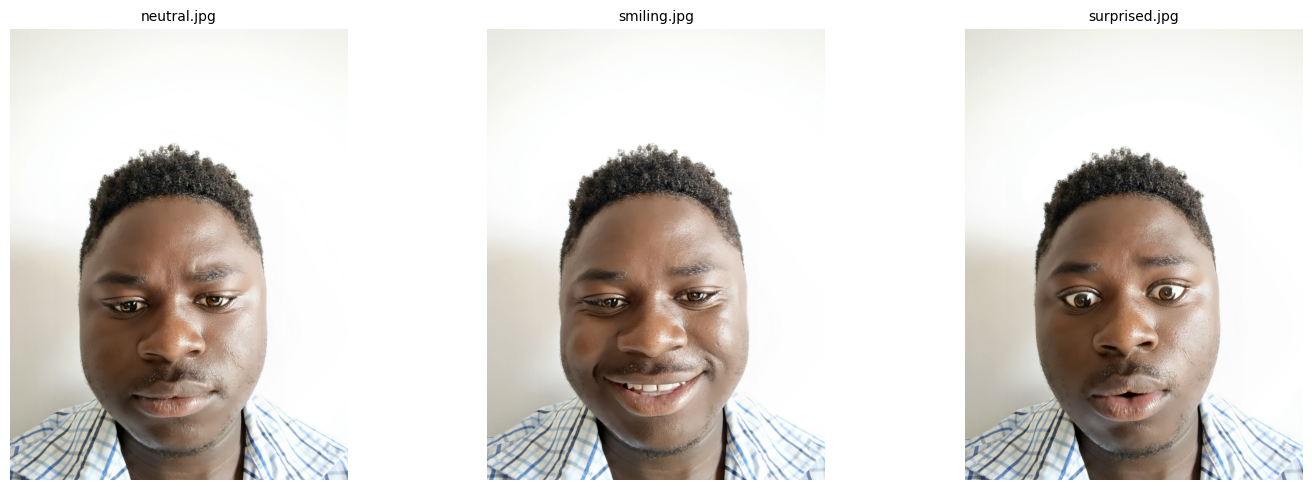


Images for: Leny


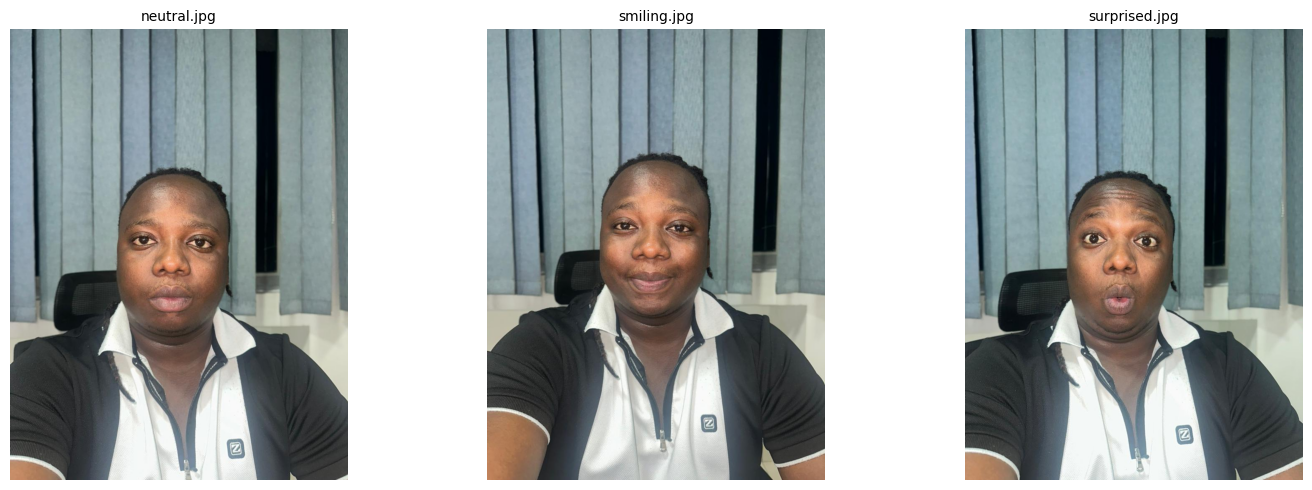


Images for: jinelle


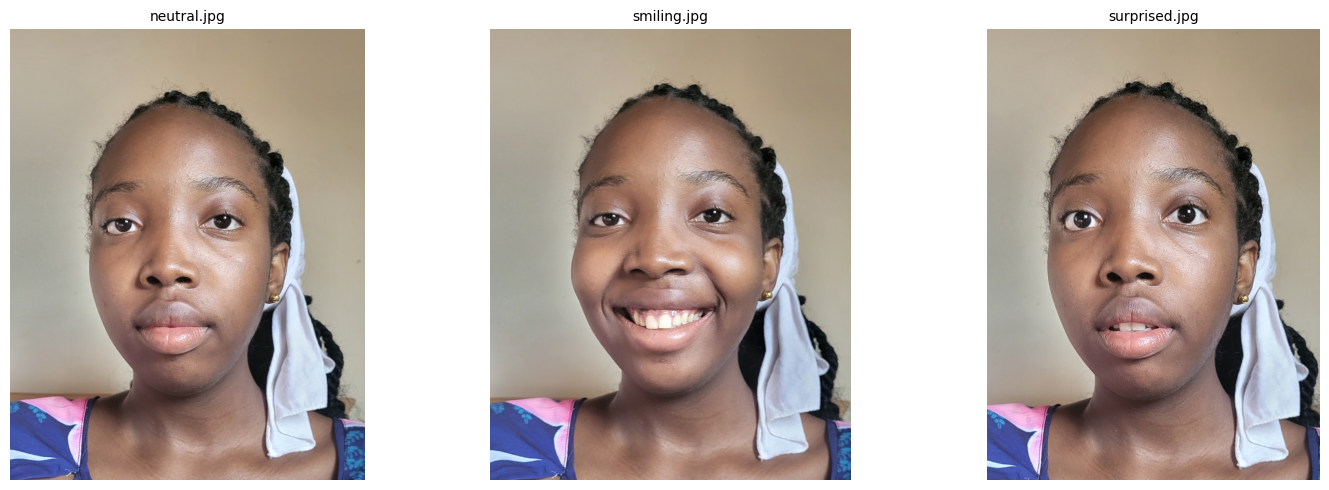


Images for: Emmanuel


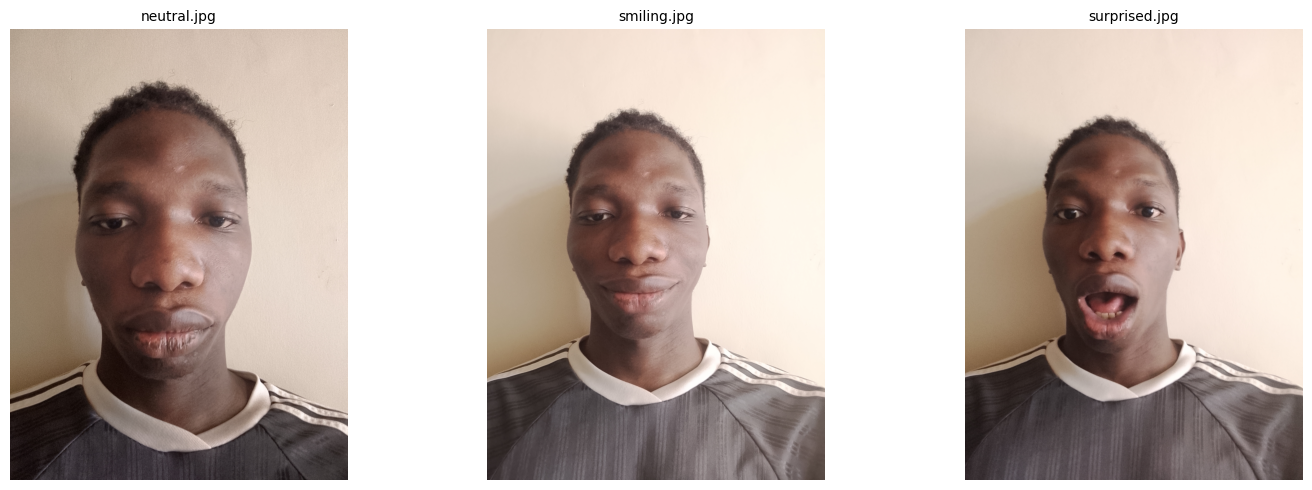


Images for: unauthorized


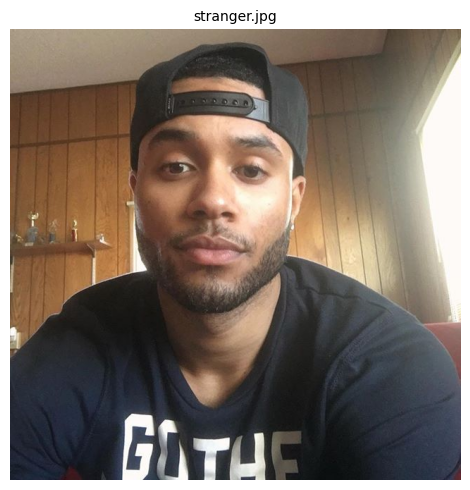

In [3]:
def display_images(base_dir, team_members):
    """
    Display all images for each team member
    """ 
    for member in team_members:
        member_path = os.path.join(base_dir, member)
        
        if not os.path.exists(member_path):
            print(f"Warning: {member_path} does not exist")
            continue
        
        images = [f for f in os.listdir(member_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if len(images) == 0:
            print(f"No images found for {member}")
            continue
        
        print(f"\n{'='*50}")
        print(f"Images for: {member}")
        print(f"{'='*50}")
        
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        
        if len(images) == 1:
            axes = [axes]
        
        for idx, img_name in enumerate(images):
            img_path = os.path.join(member_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(img_name, fontsize=10)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

# Display all images
display_images(base_dir, team_members)

## Step 5: Image Augmentation

Apply multiple augmentations to each image:
- Rotation
- Horizontal flip
- Grayscale
- Brightness adjustment
- Zoom/Crop

In [4]:
def augment_image(image_path, output_folder, person_name):
    """
    Apply multiple augmentations to a single image
    
    Args:
        image_path: Path to original image
        output_folder: Where to save augmented images
        person_name: Name of the person (for naming files)
    
    Returns:
        List of paths to augmented images
    """
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return []
    
    base_name = os.path.basename(image_path).split('.')[0]
    augmented_paths = []
    
    # 1. Original
    original_path = os.path.join(output_folder, f"{base_name}_original.jpg")
    cv2.imwrite(original_path, img)
    augmented_paths.append(original_path)
    
    # 2. Rotation (+15 degrees)
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 15, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    rotated_path = os.path.join(output_folder, f"{base_name}_rotated.jpg")
    cv2.imwrite(rotated_path, rotated)
    augmented_paths.append(rotated_path)
    
    # 3. Rotation (-15 degrees)
    M = cv2.getRotationMatrix2D(center, -15, 1.0)
    rotated_neg = cv2.warpAffine(img, M, (w, h))
    rotated_neg_path = os.path.join(output_folder, f"{base_name}_rotated_neg.jpg")
    cv2.imwrite(rotated_neg_path, rotated_neg)
    augmented_paths.append(rotated_neg_path)
    
    # 4. Horizontal flip
    flipped = cv2.flip(img, 1)
    flipped_path = os.path.join(output_folder, f"{base_name}_flipped.jpg")
    cv2.imwrite(flipped_path, flipped)
    augmented_paths.append(flipped_path)
    
    # 5. Grayscale (converted back to 3-channel for consistency)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_3channel = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    gray_path = os.path.join(output_folder, f"{base_name}_gray.jpg")
    cv2.imwrite(gray_path, gray_3channel)
    augmented_paths.append(gray_path)
    
    # 6. Brightness increase
    bright = cv2.convertScaleAbs(img, alpha=1.3, beta=30)
    bright_path = os.path.join(output_folder, f"{base_name}_bright.jpg")
    cv2.imwrite(bright_path, bright)
    augmented_paths.append(bright_path)
    
    # 7. Brightness decrease
    dark = cv2.convertScaleAbs(img, alpha=0.7, beta=-30)
    dark_path = os.path.join(output_folder, f"{base_name}_dark.jpg")
    cv2.imwrite(dark_path, dark)
    augmented_paths.append(dark_path)
    
    # 8. Zoom (crop center and resize)
    crop_size = int(min(h, w) * 0.8)
    start_x = (w - crop_size) // 2
    start_y = (h - crop_size) // 2
    cropped = img[start_y:start_y+crop_size, start_x:start_x+crop_size]
    zoomed = cv2.resize(cropped, (w, h))
    zoomed_path = os.path.join(output_folder, f"{base_name}_zoomed.jpg")
    cv2.imwrite(zoomed_path, zoomed)
    augmented_paths.append(zoomed_path)
    
    return augmented_paths


def augment_all_images(base_dir, augmented_dir, team_members):
    """
    Augment all images for all team members
    """
    total_augmented = 0
    
    for member in team_members:
        member_input = os.path.join(base_dir, member)
        member_output = os.path.join(augmented_dir, member)
        
        if not os.path.exists(member_input):
            continue
        
        images = [f for f in os.listdir(member_input) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"\nAugmenting images for {member}...")
        
        for img_name in images:
            img_path = os.path.join(member_input, img_name)
            augmented = augment_image(img_path, member_output, member)
            total_augmented += len(augmented)
            print(f"  - {img_name}: {len(augmented)} variations created")
    
    print(f"\n{'='*50}")
    print(f"Total augmented images created: {total_augmented}")
    print(f"{'='*50}")
    
    return total_augmented

# Run augmentation
total = augment_all_images(base_dir, augmented_dir, team_members)


Augmenting images for wilsons...
  - neutral.jpg: 8 variations created
  - smiling.jpg: 8 variations created
  - surprised.jpg: 8 variations created

Augmenting images for Leny...
  - neutral.jpg: 8 variations created
  - smiling.jpg: 8 variations created
  - surprised.jpg: 8 variations created

Augmenting images for jinelle...
  - neutral.jpg: 8 variations created
  - smiling.jpg: 8 variations created
  - surprised.jpg: 8 variations created

Augmenting images for Emmanuel...
  - neutral.jpg: 8 variations created
  - smiling.jpg: 8 variations created
  - surprised.jpg: 8 variations created

Augmenting images for unauthorized...
  - stranger.jpg: 8 variations created

Total augmented images created: 104


## Step 6: Display Augmented Images

Visualize the augmentations for one person

Displaying augmentations for wilsons - neutral


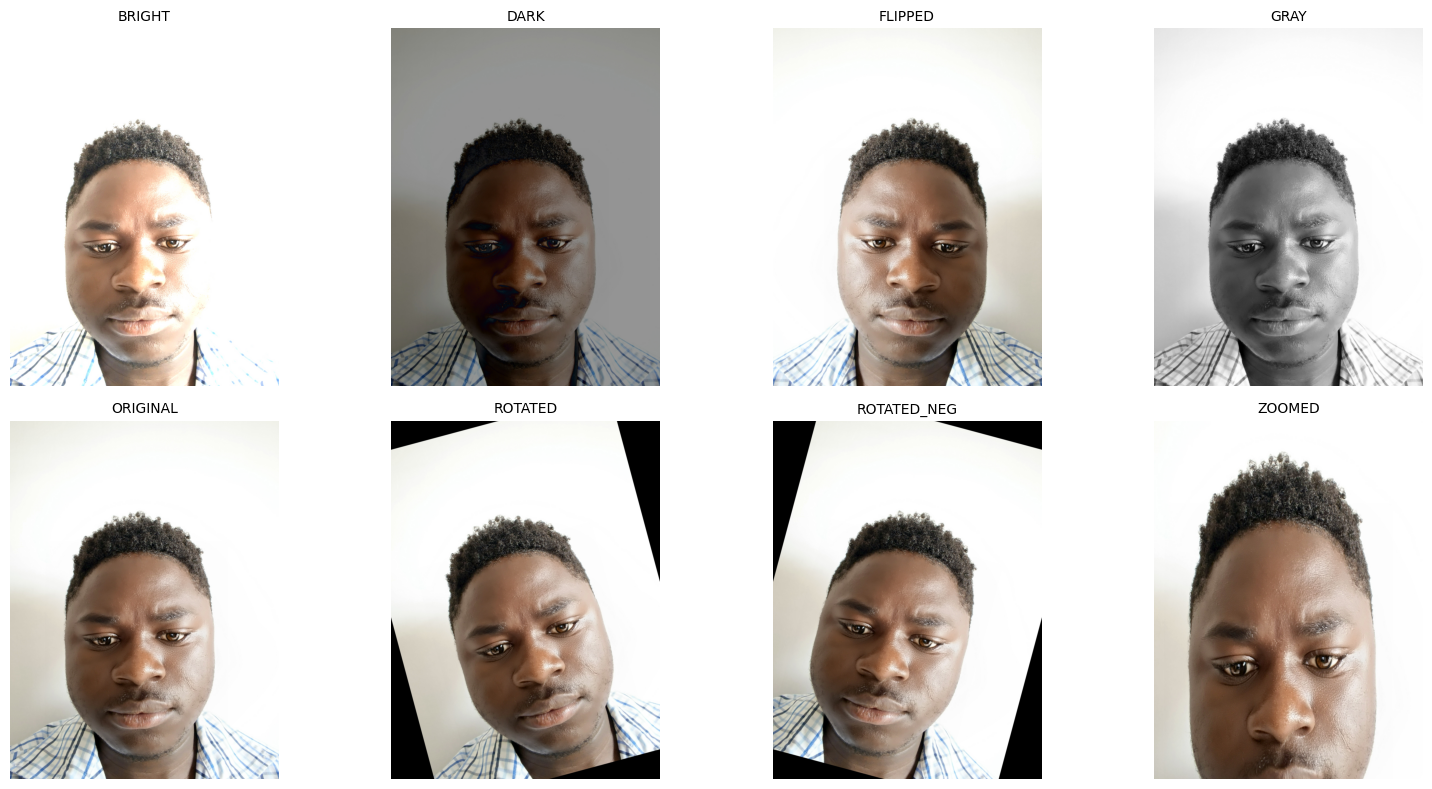

In [5]:
def display_augmentations(augmented_dir, person_name, base_image_name='neutral'):
    """
    Display all augmentations for a specific image
    """
    person_folder = os.path.join(augmented_dir, person_name)
    
    if not os.path.exists(person_folder):
        print(f"Folder not found: {person_folder}")
        return
    
    # Get all augmented versions of the base image
    images = [f for f in os.listdir(person_folder) if base_image_name in f and f.endswith('.jpg')]
    images.sort()
    
    if len(images) == 0:
        print(f"No augmented images found for {base_image_name}")
        return
    
    print(f"Displaying augmentations for {person_name} - {base_image_name}")
    
    # Display in grid
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, img_name in enumerate(images[:8]):
        img_path = os.path.join(person_folder, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        # Extract augmentation type from filename
        aug_type = img_name.replace(f"{base_image_name}_", "").replace(".jpg", "")
        axes[idx].set_title(aug_type.upper(), fontsize=10)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display augmentations for first team member
if len(team_members) > 0:
    display_augmentations(augmented_dir, team_members[0], 'neutral')

## Step 7: Feature Extraction Using Deep Learning

Use **DeepFace** with **Facenet512** model to extract 512-dimensional face embeddings

In [6]:
def extract_face_embeddings(image_path, person_name, model_name='Facenet512'):
    """
    Extract face embeddings using DeepFace
    
    Args:
        image_path: Path to image
        person_name: Label for the person
        model_name: Model to use (Facenet512, VGG-Face, ArcFace, etc.)
    
    Returns:
        Dictionary with person name and feature vector
    """
    try:
        # Extract embeddings
        embedding = DeepFace.represent(
            img_path=image_path,
            model_name=model_name,
            enforce_detection=False,  # Set to True for stricter face detection
            detector_backend='opencv'
        )
        
        # Get feature vector
        feature_vector = embedding[0]['embedding']
        
        # Create feature dictionary
        features = {
            'person': person_name,
            'image_path': image_path,
            'image_name': os.path.basename(image_path)
        }
        
        # Add each embedding dimension as a feature
        for i, val in enumerate(feature_vector):
            features[f'feature_{i}'] = val
        
        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


def extract_all_features(augmented_dir, team_members, model_name='Facenet512'):
    """
    Extract features from all augmented images
    """
    all_features = []
    total_processed = 0
    total_failed = 0
    
    print(f"Extracting features using {model_name}...\n")
    
    for member in team_members:
        member_path = os.path.join(augmented_dir, member)
        
        if not os.path.exists(member_path):
            continue
        
        images = [f for f in os.listdir(member_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Processing {member}: {len(images)} images")
        
        for img_name in images:
            img_path = os.path.join(member_path, img_name)
            features = extract_face_embeddings(img_path, member, model_name)
            
            if features:
                all_features.append(features)
                total_processed += 1
            else:
                total_failed += 1
        
        print(f"  ✓ Completed {member}\n")
    
    print(f"{'='*50}")
    print(f"Feature extraction complete!")
    print(f"Successfully processed: {total_processed}")
    print(f"Failed: {total_failed}")
    print(f"{'='*50}")
    
    return all_features

# Extract features from all images
features_list = extract_all_features(augmented_dir, team_members, model_name='Facenet512')

Extracting features using Facenet512...

Processing wilsons: 24 images
  ✓ Completed wilsons

Processing Leny: 24 images
  ✓ Completed Leny

Processing jinelle: 24 images
  ✓ Completed jinelle

Processing Emmanuel: 24 images
  ✓ Completed Emmanuel

Processing unauthorized: 8 images
  ✓ Completed unauthorized

Feature extraction complete!
Successfully processed: 104
Failed: 0


## Step 8: Save Features to CSV

In [7]:
# Convert to DataFrame
df_features = pd.DataFrame(features_list)

# Save to CSV
output_csv = 'image_features.csv'
df_features.to_csv(output_csv, index=False)

print(f"Features saved to: {output_csv}")
print(f"\nDataset shape: {df_features.shape}")
print(f"Number of features per image: {df_features.shape[1] - 3}")
print(f"\nFirst few rows:")
print(df_features[['person', 'image_name']].head(10))

# Check class distribution
print(f"\nClass distribution:")
print(df_features['person'].value_counts())

Features saved to: image_features.csv

Dataset shape: (104, 515)
Number of features per image: 512

First few rows:
    person               image_name
0  wilsons       neutral_bright.jpg
1  wilsons         neutral_dark.jpg
2  wilsons      neutral_flipped.jpg
3  wilsons         neutral_gray.jpg
4  wilsons     neutral_original.jpg
5  wilsons      neutral_rotated.jpg
6  wilsons  neutral_rotated_neg.jpg
7  wilsons       neutral_zoomed.jpg
8  wilsons       smiling_bright.jpg
9  wilsons         smiling_dark.jpg

Class distribution:
person
wilsons         24
Leny            24
jinelle         24
Emmanuel        24
unauthorized     8
Name: count, dtype: int64


## Step 9: Prepare Data for Model Training

In [8]:
# Load features
df = pd.read_csv('image_features.csv')

# Separate features (X) and labels (y)
X = df.drop(['person', 'image_path', 'image_name'], axis=1)
y = df['person']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nUnique persons: {y.unique()}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures balanced split across classes
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features shape: (104, 512)
Labels shape: (104,)

Unique persons: ['wilsons' 'Leny' 'jinelle' 'Emmanuel' 'unauthorized']

Training set: 83 samples
Test set: 21 samples


## Step 10: Train Facial Recognition Model

In [9]:
# Train Random Forest Classifier
print("Training Random Forest model...\n")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

model.fit(X_train, y_train)

print("✓ Model training complete!")

Training Random Forest model...

✓ Model training complete!


## Step 11: Model Evaluation

In [10]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display results
print("="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"\nTraining Set Performance:")
print(f"  Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  F1-Score: {train_f1:.4f}")

print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  F1-Score: {test_f1:.4f}")

print(f"\n{'='*60}")
print("Detailed Classification Report (Test Set)")
print("="*60)
print(classification_report(y_test, y_test_pred))

MODEL EVALUATION RESULTS

Training Set Performance:
  Accuracy: 1.0000 (100.00%)
  F1-Score: 1.0000

Test Set Performance:
  Accuracy: 0.8571 (85.71%)
  F1-Score: 0.8445

Detailed Classification Report (Test Set)
              precision    recall  f1-score   support

    Emmanuel       1.00      0.80      0.89         5
        Leny       1.00      1.00      1.00         5
     jinelle       1.00      0.80      0.89         5
unauthorized       0.00      0.00      0.00         1
     wilsons       0.62      1.00      0.77         5

    accuracy                           0.86        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.86      0.86      0.84        21



## Step 12: Confusion Matrix Visualization

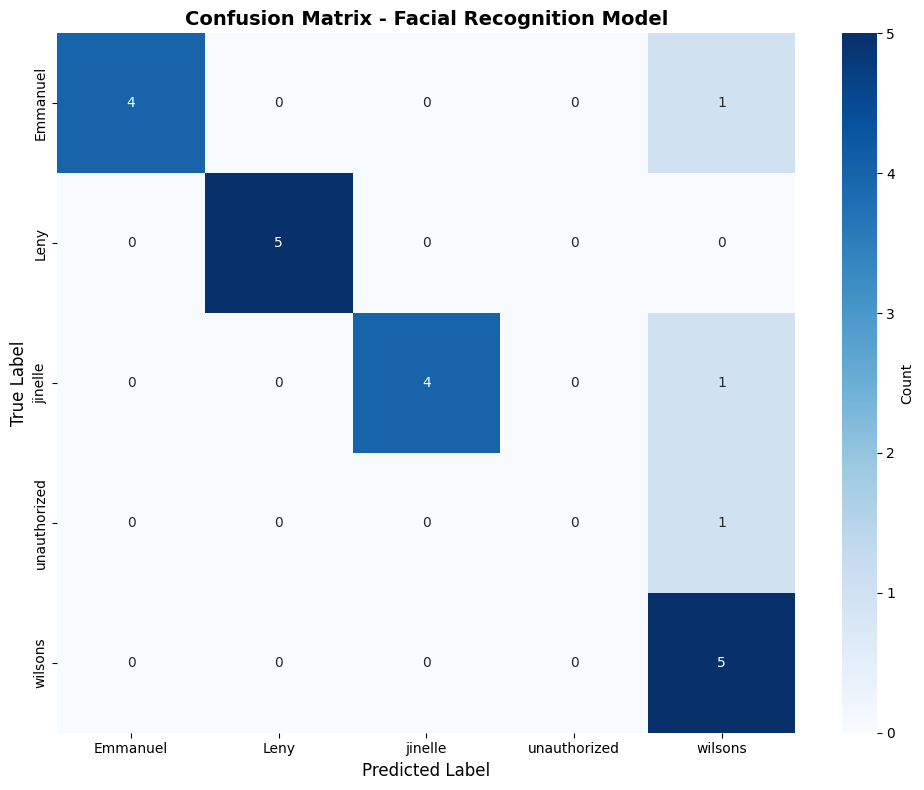

In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Facial Recognition Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## Step 13: Save the Trained Model

In [12]:
# Save model
model_filename = 'facial_recognition_model.pkl'
joblib.dump(model, model_filename)

print(f"✓ Model saved to: {model_filename}")

# Save feature columns for later use
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl')

print(f"✓ Feature columns saved")

✓ Model saved to: facial_recognition_model.pkl
✓ Feature columns saved


## Step 14: Test Prediction Function

Create a function to recognize faces in new images

In [13]:
def recognize_face(image_path, model, feature_columns, threshold=0.6, model_name='Facenet512'):
    """
    Recognize a face in an image
    
    Args:
        image_path: Path to image file
        model: Trained classification model
        feature_columns: List of feature column names
        threshold: Minimum confidence threshold (0-1)
        model_name: DeepFace model name
    
    Returns:
        Tuple of (predicted_person, confidence)
    """
    try:
        # Extract features
        features = extract_face_embeddings(image_path, "unknown", model_name)
        
        if features is None:
            return "unauthorized", 0.0
        
        # Prepare feature vector
        feature_vector = [features[col] for col in feature_columns]
        X_input = np.array(feature_vector).reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(X_input)[0]
        probabilities = model.predict_proba(X_input)[0]
        confidence = max(probabilities)
        
        # Check confidence threshold
        if confidence < threshold:
            return "unauthorized", confidence
        
        return prediction, confidence
        
    except Exception as e:
        print(f"Error during recognition: {str(e)}")
        return "error", 0.0


def test_recognition_with_visualization(image_path, model, feature_columns, threshold=0.6):
    """
    Test recognition and display result with image
    """
    person, confidence = recognize_face(image_path, model, feature_columns, threshold)
    
    # Display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    
    if person == "unauthorized":
        title = f"❌ UNAUTHORIZED\nConfidence: {confidence:.2%}"
        color = 'red'
    else:
        title = f"✓ Recognized: {person}\nConfidence: {confidence:.2%}"
        color = 'green'
    
    plt.title(title, fontsize=14, fontweight='bold', color=color)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return person, confidence

print("Recognition functions ready!")

Recognition functions ready!


## Step 15: Test Recognition on Sample Images

Testing recognition on sample images...


Test 31:
True person: Leny


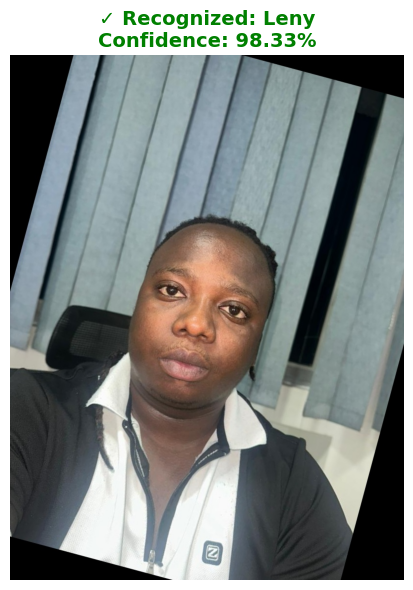

Predicted: Leny (Confidence: 98.33%)
--------------------------------------------------

Test 66:
True person: jinelle


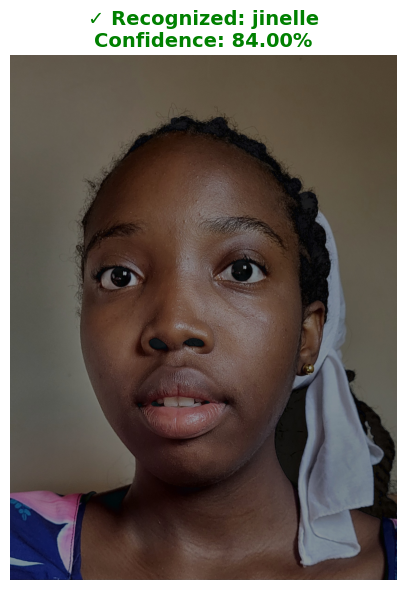

Predicted: jinelle (Confidence: 84.00%)
--------------------------------------------------

Test 65:
True person: jinelle


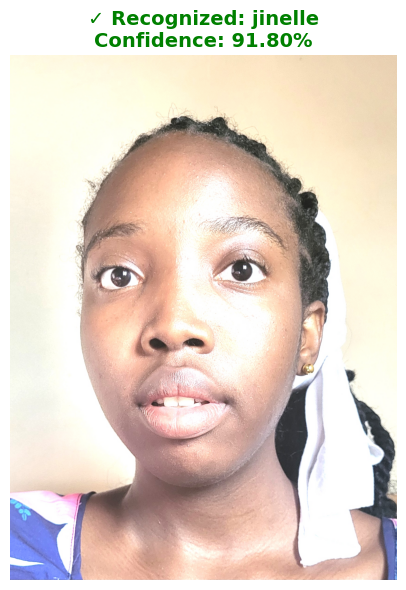

Predicted: jinelle (Confidence: 91.80%)
--------------------------------------------------


In [15]:
# Test on a few images from test set
print("Testing recognition on sample images...\n")

# Get some test image paths
test_samples = df.sample(3, random_state=42)

for idx, row in test_samples.iterrows():
    print(f"\nTest {idx + 1}:")
    print(f"True person: {row['person']}")
    person, conf = test_recognition_with_visualization(
        row['image_path'], 
        model, 
        feature_columns,
        threshold=0.5
    )
    print(f"Predicted: {person} (Confidence: {conf:.2%})")
    print("-" * 50)

## Step 16: Test Unauthorized Access


Testing UNAUTHORIZED access attempt...



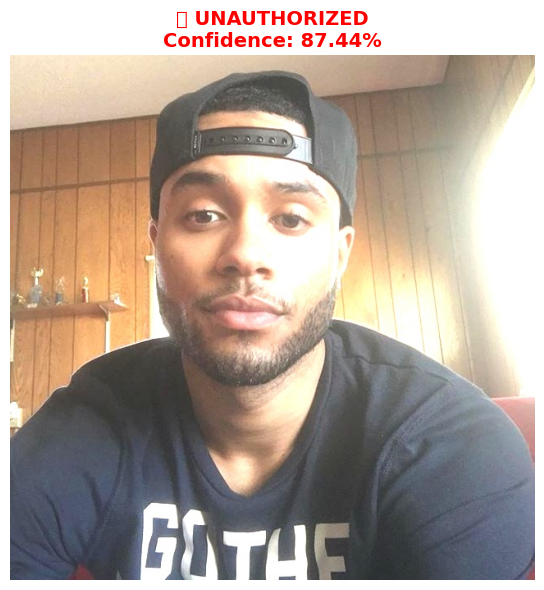

✓ Correctly rejected unauthorized person


In [16]:
# Test with unauthorized person (if available)
unauthorized_folder = os.path.join(augmented_dir, 'unauthorized')

if os.path.exists(unauthorized_folder):
    unauthorized_images = [f for f in os.listdir(unauthorized_folder) if f.endswith('.jpg')]
    
    if len(unauthorized_images) > 0:
        print("\nTesting UNAUTHORIZED access attempt...\n")
        
        test_image = os.path.join(unauthorized_folder, unauthorized_images[0])
        person, conf = test_recognition_with_visualization(
            test_image,
            model,
            feature_columns,
            threshold=0.6
        )
        
        if person == "unauthorized":
            print("✓ Correctly rejected unauthorized person")
        else:
            print(f"⚠ Warning: Unauthorized person recognized as {person}")
    else:
        print("No unauthorized images found for testing")
else:
    print("Unauthorized folder not found. Add images to test unauthorized access.")

## Step 17: Summary and Next Steps

In [17]:
print("="*70)
print("FACIAL RECOGNITION PIPELINE - SUMMARY")
print("="*70)

print(f"\n✓ Images collected and augmented: {len(df)} total images")
print(f"✓ Features extracted: {X.shape[1]} features per image")
print(f"✓ Model trained: Random Forest Classifier")
print(f"✓ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"✓ Test F1-Score: {test_f1:.4f}")

print("\n" + "="*70)
print("FILES CREATED")
print("="*70)
print(f"  1. image_features.csv - Extracted features dataset")
print(f"  2. facial_recognition_model.pkl - Trained model")
print(f"  3. feature_columns.pkl - Feature column names")
print(f"  4. facial_data_augmented/ - Augmented images folder")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("  1. Build the Voice Recognition model (audio_features.csv)")
print("  2. Merge with customer data for Product Recommendation model")
print("  3. Create command-line application integrating all 3 models")
print("  4. Test full authentication flow: Face → Voice → Product")
print("\n")

FACIAL RECOGNITION PIPELINE - SUMMARY

✓ Images collected and augmented: 104 total images
✓ Features extracted: 512 features per image
✓ Model trained: Random Forest Classifier
✓ Test Accuracy: 85.71%
✓ Test F1-Score: 0.8445

FILES CREATED
  1. image_features.csv - Extracted features dataset
  2. facial_recognition_model.pkl - Trained model
  3. feature_columns.pkl - Feature column names
  4. facial_data_augmented/ - Augmented images folder

NEXT STEPS
  1. Build the Voice Recognition model (audio_features.csv)
  2. Merge with customer data for Product Recommendation model
  3. Create command-line application integrating all 3 models
  4. Test full authentication flow: Face → Voice → Product


